# Aula 14 - Vieses em Sistemas de Recomendação - Exercícios

In [1]:
!pip install surprise

In [2]:
import pandas as pd
import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import KFold
from surprise.prediction_algorithms.knns import KNNBasic

## Vídeos de Apoio

https://www.youtube.com/watch?v=OSv5J1EVEqA

https://www.youtube.com/watch?v=abGCaK86tY4


## Exercícios de Vieses

### Download do Dataset

In [3]:
!wget https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/steam-200k.csv  -O ./steam-200k.csv

--2024-11-12 17:04:30--  https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/steam-200k.csv
Resolvendo raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8002::154, 2606:50c0:8000::154, ...
Conectando-se a raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 2268468 (2,2M) [text/plain]
Salvando em: ‘./steam-200k.csv’

./steam-200k.csv    100%[===================>]   2,16M  3,71MB/s    em 0,6s    

2024-11-12 17:04:31 (3,71 MB/s) - ‘./steam-200k.csv’ salvo [2268468/2268468]



### Funções comuns

In [3]:
import surprise.dataset as data

In [5]:
df = pd.read_csv("./steam-200k.csv")
df['hours_played'] = np.log10(df['hours_played'])/np.log10(df['hours_played']).max()
df['user_id'] = df['user_id'].astype(str)
df.head()


,user_id,game_title,hours_played
0,151603712,The Elder Scrolls V Skyrim,0.598538
1,151603712,Fallout 4,0.476519
2,151603712,Spore,0.288239
3,151603712,Fallout New Vegas,0.266028
4,151603712,Left 4 Dead 2,0.233255


In [6]:
n_jogos = len(df['game_title'].unique())
n_usuarios = len(df['user_id'].unique())

print("Numero de Usuarios: ", n_usuarios)
print("Numero de Jogos: ", n_jogos)

Numero de Usuarios:  11350
Numero de Jogos:  3600


In [7]:

train, test = train_test_split(df, test_size=.3, random_state=42)

soma_interacoes_por_jogo = train.groupby('game_title').count()[['hours_played']]
soma_interacoes_por_jogo.columns = ['interactions']

map_soma = soma_interacoes_por_jogo.to_dict()['interactions']

soma_interacoes_por_jogo.head(5)

soma_interacoes_por_jogo_ordenado = soma_interacoes_por_jogo.sort_values('interactions', ascending=False)

map_id = dict(list(enumerate(soma_interacoes_por_jogo_ordenado.index)))
map_id = {v:k for k,v in map_id.items()}

jogos_maior_20porcento_nome = soma_interacoes_por_jogo_ordenado.reset_index().values[:11, 0]
jogos_menor_20porcento_nome = soma_interacoes_por_jogo_ordenado.reset_index().values[-2680:, 0]

jogos_entre_os_20porcento = set(df['game_title']) - set(jogos_maior_20porcento_nome) - set(jogos_menor_20porcento_nome)

In [8]:
block_buster_group = []
niche_group = []
diverse_group = []

for user_id in train['user_id'].unique():
    interacted_by_user = train[train['user_id'] == user_id]
    high_pop = interacted_by_user[interacted_by_user['game_title'].isin(jogos_maior_20porcento_nome)]
    lowest_pop = interacted_by_user[interacted_by_user['game_title'].isin(jogos_menor_20porcento_nome)]

    if len(high_pop)/len(interacted_by_user) > 0.5:
        block_buster_group.append(user_id)
    elif len(lowest_pop)/len(interacted_by_user) > 0.5:
        niche_group.append(user_id)
    else:
        diverse_group.append(user_id)


In [4]:
def item_is_relevant(user_id, item_id):
    aux = df[df["user_id"] == user_id]
    if item_id in list(aux['game_title']):
        return True
    return False

def calculate_MRR(map_recommendations):

    MRR = 0
    for user_id in map_recommendations:
        user_find_corerect_item = False
        for index, (item, score) in enumerate(map_recommendations[user_id]):
            if user_find_corerect_item is False:
                if item_is_relevant(user_id, item):
                    MRR += (1/(index+1))
                    user_find_corerect_item = True
        
    return MRR/len(map_recommendations)


def calculate_gap_profile(train, user_id):
    list_items = train[train['user_id'] == user_id]['game_title'].values
    gap = sum([map_soma[i] for i in list_items])
    return gap/len(list_items)
    

def calculate_gap(list_items):
    gap = sum([map_soma.get(i, 0) for i in list_items])
    return gap/len(list_items)

def calculate_gap_groups(predictions):
    gap_bb_rec1 = 0
    gap_d_rec1 = 0
    gap_n_rec1 = 0

    n_bb, n_d, n_n = 0, 0, 0

    for user, reclist in zip(test['user_id'].unique()[:200], predictions):
        if user in block_buster_group:
            n_bb += 1
            gap_bb_rec1 += calculate_gap([i[0] for i in predictions[reclist]])
        elif user in niche_group:
            n_n += 1
            gap_n_rec1 += calculate_gap([i[0] for i in predictions[reclist]])
        else:
            n_d += 1
            gap_d_rec1 += calculate_gap([i[0] for i in predictions[reclist]])

    gap_bb_rec1 = gap_bb_rec1/n_bb
    gap_d_rec1 = gap_d_rec1/n_d
    gap_n_rec1 = gap_n_rec1/n_n
    
    delta_gab_bb = (gap_bb_rec1 - gap_bb_profile )/gap_bb_profile
    delta_gab_d = (gap_d_rec1 - gap_d_profile )/gap_d_profile
    delta_gab_n = (gap_n_rec1 - gap_n_profile )/gap_n_profile
    
    return delta_gab_bb, delta_gab_d, delta_gab_n

def get_recommendation(model, alpha=0.5):
    
    prediction_user_map = {}
    prediction_user_map_corrected = {}

    for user in test['user_id'].unique()[:200]:

        data = {"game_title": list(set(df["game_title"].unique()))}
        user_testset_df = pd.DataFrame(data)
        user_testset_df["hours_played"] = 0.0
        user_testset_df["user_id"] = user

        testset = (
            Dataset.load_from_df(
                user_testset_df[["user_id", "game_title", "hours_played"]],
                reader=reader,
            )
            .build_full_trainset()
            .build_testset()
        )
        
        pred_list = model.test(testset)
        
        predictions = sorted(
            [(pred.iid, pred.est)for pred in pred_list if ((pred.uid == user))],
            key=lambda x: x[1],reverse=True
        )
        
        predictions_corrected = sorted(
            [(pred.iid, (1-alpha)*pred.est + (alpha/np.log(map_soma.get(pred.iid, 1)+1)) )for pred in pred_list if ((pred.uid == user))],
            key=lambda x: x[1],reverse=True
        )
        
        prediction_user_map[user] = predictions[:10]
        prediction_user_map_corrected[user] = predictions_corrected[:10]

                
    return prediction_user_map, prediction_user_map_corrected

In [10]:
gap_bb_profile = np.mean([calculate_gap_profile(train, i) for i in block_buster_group])
gap_n_profile = np.mean([calculate_gap_profile(train, i) for i in niche_group])
gap_d_profile = np.mean([calculate_gap_profile(train, i) for i in diverse_group])
gap_bb_profile, gap_n_profile, gap_d_profile

(2446.012039943106, 24.63106397647737, 275.0086012684163)

**Dados de popularidade**

In [20]:
soma_interacoes_por_jogo = train.groupby('game_title').count()[['hours_played']]
soma_interacoes_por_jogo.columns = ['interactions']

map_soma = soma_interacoes_por_jogo.to_dict()['interactions']

soma_interacoes_por_jogo.head(5)

soma_interacoes_por_jogo_ordenado = soma_interacoes_por_jogo.sort_values('interactions', ascending=False)

map_id = dict(list(enumerate(soma_interacoes_por_jogo_ordenado.index)))
map_id = {v:k for k,v in map_id.items()}



In [38]:
soma_interacoes_por_jogo_ordenado

,interactions
game_title,
Dota 2,3354
Team Fortress 2,1656
Counter-Strike Global Offensive,981
Unturned,784
Left 4 Dead 2,589
...,...
Farlight Explorers,1
R.B.I. Baseball 15,1
Fancy Skulls,1


***Exercício 01:*** Explore como outros modelos se comportam em relação ao viés de popularidade. Tente visualizar a distribuição das recomendações e as métricas estudadas.

In [5]:
from surprise.prediction_algorithms.random_pred import NormalPredictor
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.prediction_algorithms.knns import KNNBasic

In [12]:
reader = Reader(rating_scale = (0, 1))

trainset = Dataset.load_from_df(
    train[["user_id", "game_title", "hours_played"]], reader=reader
).build_full_trainset()

In [13]:
testset =  Dataset.load_from_df(
    test[["user_id", "game_title", "hours_played"]], reader=reader
).build_full_trainset().build_testset()

In [14]:
svd = SVD(n_factors=20)
u_knn = KNNBasic(K=5, sim_options={"user_based": True, "similarities": 'cosine'})
i_knn = KNNBasic(K=5, sim_options={"user_based": False, "similarities": 'cosine'})
random = NormalPredictor()

In [223]:
def get_recommendation_without_correction(model):
    
    prediction_user_map = {}

    for user in test['user_id'].unique()[:200]:

        data = {"game_title": list(set(df["game_title"].unique()))}
        user_testset_df = pd.DataFrame(data)
        user_testset_df["hours_played"] = 0.0
        user_testset_df["user_id"] = user

        testset = (
            Dataset.load_from_df(
                user_testset_df[["user_id", "game_title", "hours_played"]],
                reader=reader,
            )
            .build_full_trainset()
            .build_testset()
        )
        
        pred_list = model.test(testset)
        
        predictions = sorted(
            [(pred.iid, pred.est)for pred in pred_list if ((pred.uid == user))],
            key=lambda x: x[1],reverse=True
        )
        prediction_user_map[user] = predictions[:10]

    return prediction_user_map

In [204]:
def plot_recommendation_distribution_by_popularity(recs, title):
    freqs = {}
    for user, items in recs.items():
        for item_title, item_id in items:
            if item_title in map_id:
                if item_title not in freqs:
                    freqs[item_title] = 1
                else:
                    freqs[item_title] += 1
    
    row = []
    for k,v in freqs.items():
        row.append([k, map_id[k], v])
    
    rec_freq_df = pd.DataFrame(row, columns=["game_title", "id", "freq"])
    
    interactions = soma_interacoes_por_jogo_ordenado.reset_index()
    plot_df = rec_freq_df.sort_values(by="freq", ascending=False).merge(interactions,  on="game_title").sort_values(by="interactions", ascending=False)
    
    
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    sns.lineplot(x='id', y='interactions', data=plot_df, ax=ax1, label='Popularidade', color='blue')
    ax1.set_xlabel('Recommendation ID')
    ax1.set_ylabel('Popularidade', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    sns.lineplot(x='id', y='freq', data=plot_df, ax=ax2, label='Frequencia', color='red')
    ax2.set_ylabel('Frequencia de recomendação', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    plt.xticks(rotation=90)
    
    plt.title(title)
    
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax2.legend(loc='upper left', bbox_to_anchor=(1, 0.85))
    
    plt.tight_layout()
    plt.show()

**Treinando os algoritmos**

In [16]:
svd.fit(trainset)

In [17]:
u_knn.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [18]:
i_knn.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [50]:
i_knn_pred = get_recommendation_without_correction(i_knn)

In [34]:
u_knn_pred = get_recommendation_without_correction(u_knn)

In [35]:
svd_pred = get_recommendation_without_correction(svd)

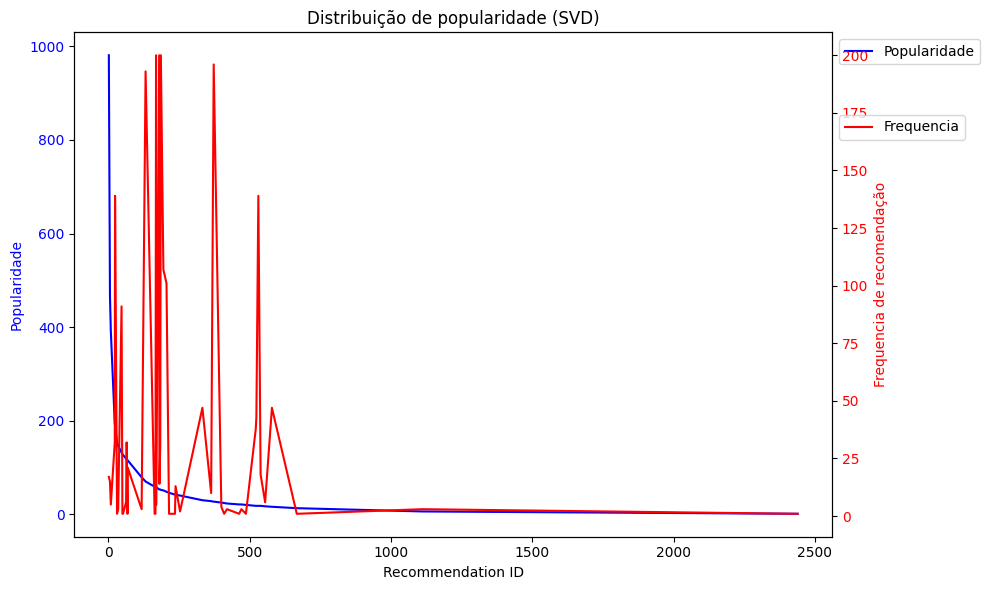

In [205]:
plot_recommendation_distribution_by_popularity(svd_pred, "Distribuição de popularidade (SVD)")

No gráfico, a frequência de recomendação está ordenada pela popularidade dos itens. Portanto, vemos que o SVD tende a recomendar itens mid. 

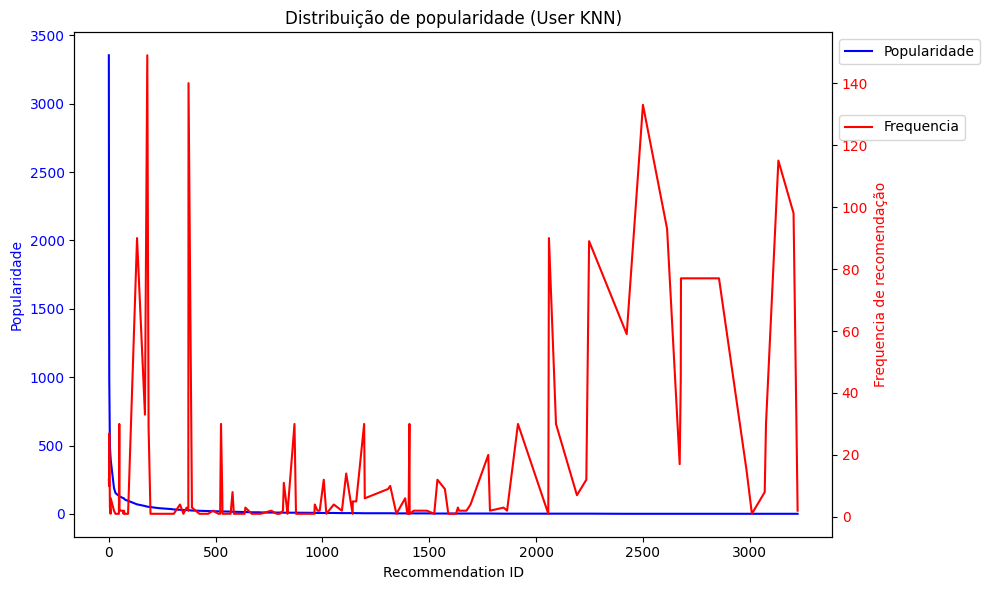

In [210]:
plot_recommendation_distribution_by_popularity(u_knn_pred, "Distribuição de popularidade (User KNN)")

Curiosamente, o USer KNN parece ter recomendado ou itens muito populares, ou pouco populares.

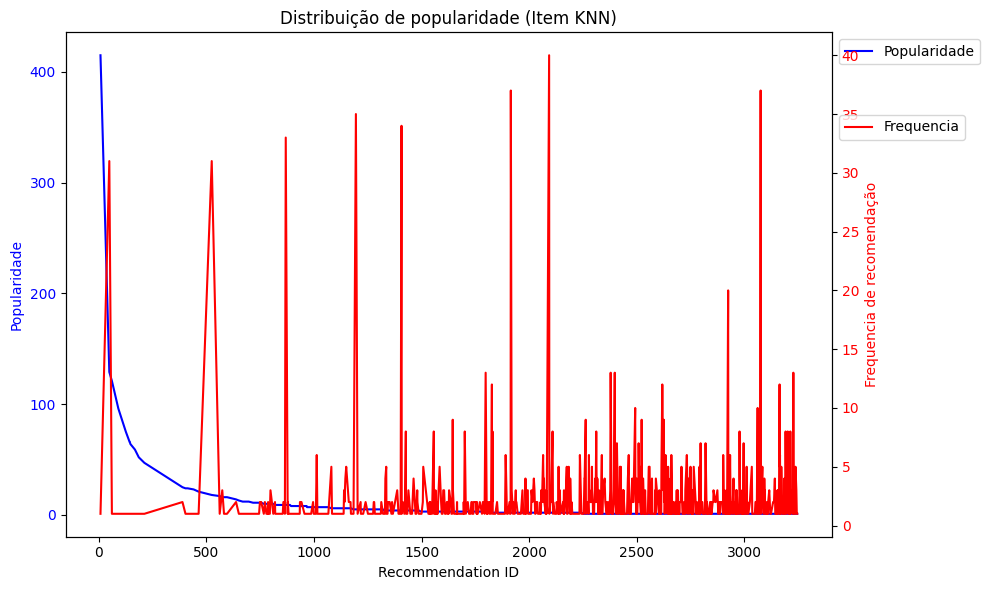

In [212]:
plot_recommendation_distribution_by_popularity(i_knn_pred, "Distribuição de popularidade (Item KNN)")

O item KNN parece ter uma distribuição mais uniforme de popularidade, excluindo outliers, porém, mais deslocada para itens menos populares.

***Exercício 02:*** Qual o efeito provocado pela variação do parâmetro $\alpha$? Demonstre como variam as métricas de acurácia e viés de popularidade com a variação do parâmetro.

In [230]:
u_knn1, u_knn2 = get_recommendation(u_knn, alpha=0.9)

In [239]:
u_knn1, u_knn2 = get_recommendation(u_knn, alpha=0.1)

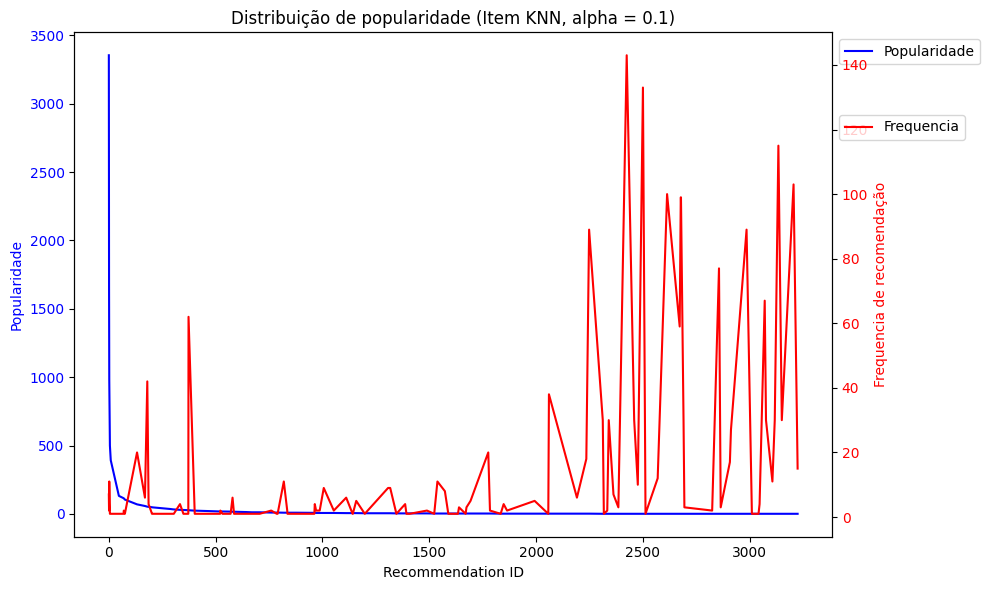

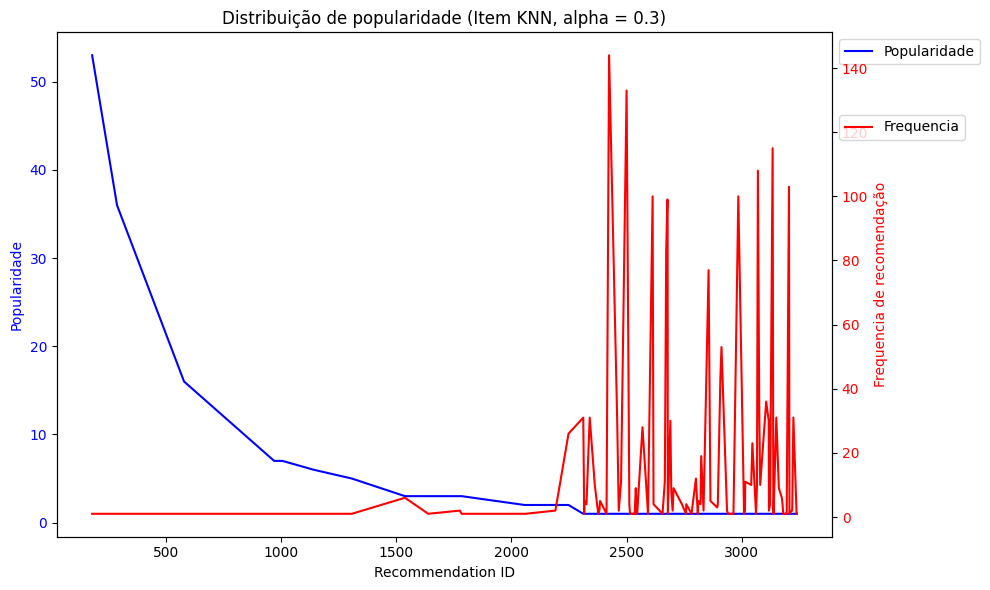

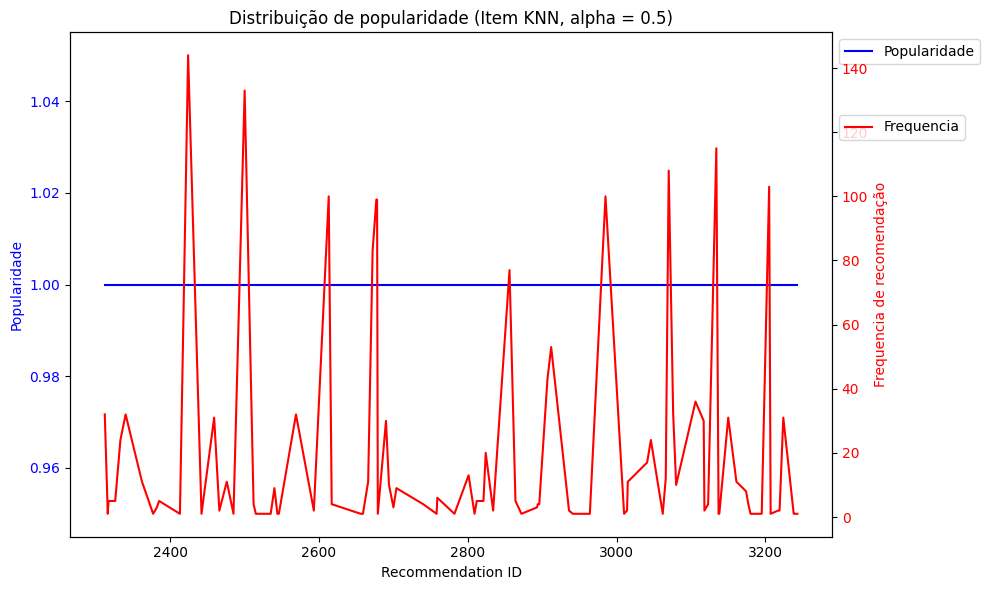

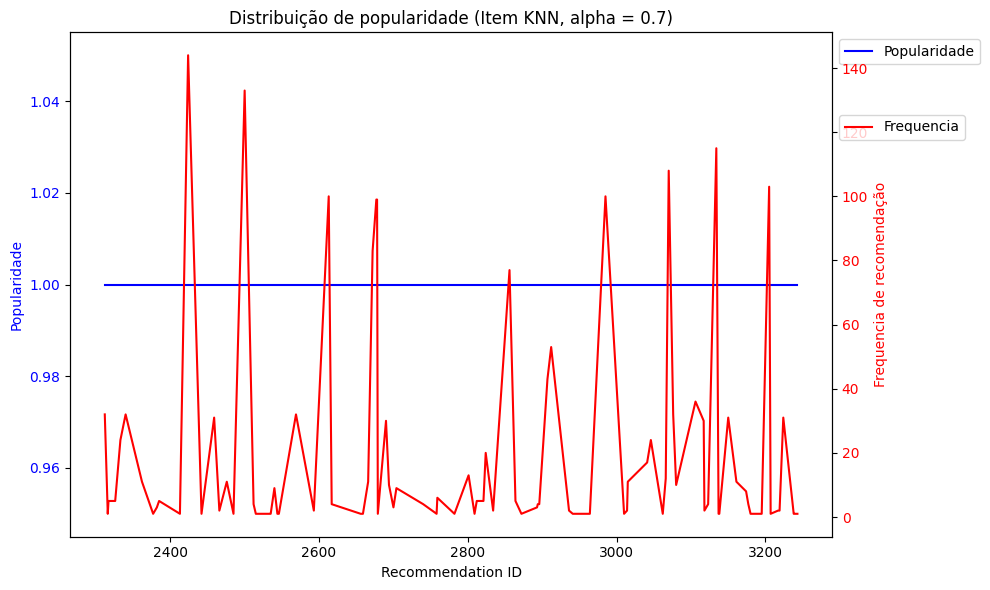

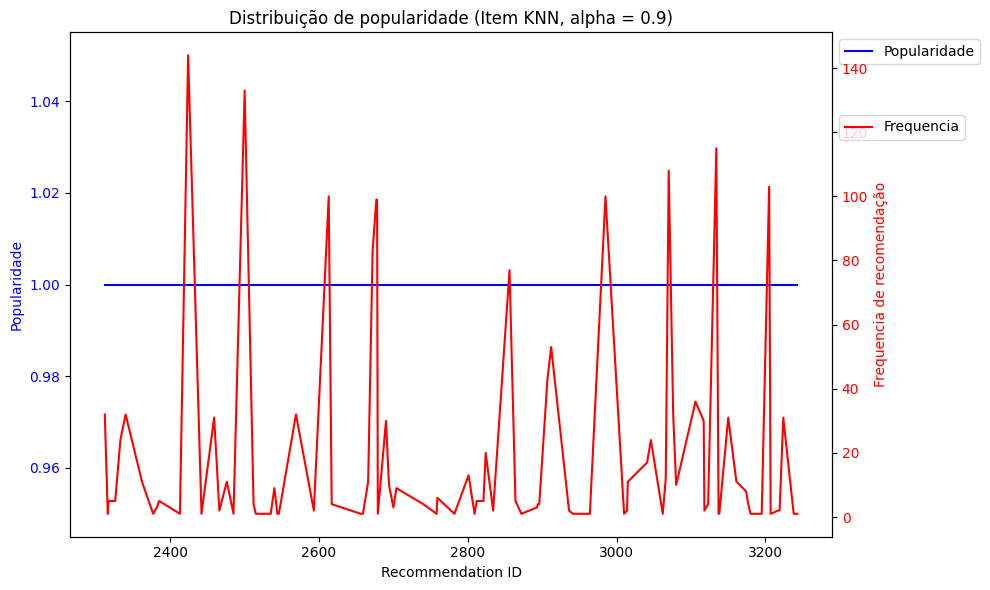

In [242]:
alphas = [0.1, 0.3, 0.5, 0.7, 0.9]

for a in alphas:
    u_knn1, u_knn2 = get_recommendation(u_knn, alpha=a)
    plot_recommendation_distribution_by_popularity(u_knn2, f"Distribuição de popularidade (Item KNN, alpha = {a})")

É interessante notar que quanto maior alpha, menor a quantidade de recomendações populares geradas: note que a curva de popularidade passa de um perfil logaritmico, para uma curva suave, para - então - uma curva horizontal. Analisando a curva de frequência, note que ela passa a se concentrar nos recommendation-ids mais altos, ou seja, aqueles que são menos populares.

## Exercícios de Fairness

In [243]:
!wget https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/ratings.dat  -O ./ratings.dat
!wget https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/movies.dat  -O ./movies.dat

--2024-11-13 08:36:58--  https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/ratings.dat
Resolvendo raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8000::154, 2606:50c0:8003::154, ...
Conectando-se a raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... conectado.
A requisição HTTP foi enviada, aguardando resposta... 200 OK
Tamanho: 4318513 (4,1M) [text/plain]
Salvando em: ‘./ratings.dat’

./ratings.dat       100%[===================>]   4,12M  4,78MB/s    em 0,9s    

2024-11-13 08:37:00 (4,78 MB/s) - ‘./ratings.dat’ salvo [4318513/4318513]

--2024-11-13 08:37:00--  https://raw.githubusercontent.com/Andre-Sacilotti/recsys_lectures/main/datasets/movies.dat
Resolvendo raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Conectando-se a raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... conect

In [6]:
df_genres = pd.read_csv("./movies.dat", sep="::", names=['item', 'title', 'genres'], encoding='ISO-8859-1')

/tmp/ipykernel_7291/3445456073.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_genres = pd.read_csv("./movies.dat", sep="::", names=['item', 'title', 'genres'], encoding='ISO-8859-1')


In [7]:
df_genres

,item,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [9]:
df = pd.read_csv("./ratings.dat", sep=",")
df_genres = pd.read_csv("./movies.dat", sep="::", names=['item', 'title', 'genres'], encoding='ISO-8859-1')
train, test = train_test_split(df, test_size=.3, random_state=42)
genre_map = {i['item']:i['genres'].split("|") for i in df_genres[['item', 'genres']].to_dict('records')}

/tmp/ipykernel_7291/2450827424.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_genres = pd.read_csv("./movies.dat", sep="::", names=['item', 'title', 'genres'], encoding='ISO-8859-1')


In [10]:
df_genres

,item,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


### Funções Comuns

In [74]:
def get_user_recommendation_distribution(prediction_user_map):
    user_rec_distribution = {}
    n = 0
    for (item, score) in prediction_user_map:
        for genre in genre_map[item]:
            if genre not in user_rec_distribution:
                user_rec_distribution[genre] = 0
            n += 1
            user_rec_distribution[genre] += 1
            
    user_rec_distribution = {k: v/n for k, v in sorted(user_rec_distribution.items(), key=lambda item: item[1])}
    return user_rec_distribution


def user_rank_miscalibration(user_profile_dist, rec_profile_dist, alpha=0.001):
    p_g_u = user_profile_dist
    q_g_u = rec_profile_dist
    
    Ckl = 0
    for genre, p in p_g_u.items():
        q = q_g_u.get(genre, 0.0)
        til_q = (1 - alpha) * q + alpha * p

        if til_q == 0 or p_g_u.get(genre, 0) == 0:
            Ckl = Ckl
        else:
            Ckl += p * np.log2(p / til_q)
    return Ckl

def get_mean_rank_miscalibration(predictions):
    MRMC = 0
    
    for user in predictions:
        RMC = 0
        user_profile_dist = get_user_profile_distribution(train, user)
        if user_profile_dist == {}:
            continue
        
        void = user_rank_miscalibration(user_profile_dist, {})
        N = len(predictions[user])
        for i in range(1, N):
            user_rec_dist = get_user_recommendation_distribution(predictions[user][:i])
            kl = user_rank_miscalibration(user_profile_dist, user_rec_dist)
            RMC += kl/void

        MRMC += RMC/N
    
    return MRMC/len(predictions)

def get_recommendation_raw(model, test):
    
    prediction_user_map = {}

    for user in test['user'].unique()[:200]:

        data = {"item": list(set(df["item"].unique()))}
        user_testset_df = pd.DataFrame(data)
        user_testset_df["rating"] = 0.0
        user_testset_df["user"] = user

        testset = (
            Dataset.load_from_df(
                user_testset_df[["user", "item", "rating"]],
                reader=reader,
            )
            .build_full_trainset()
            .build_testset()
        )
        
        pred_list = model.test(testset)
        
        predictions = sorted(
            [(pred.iid, pred.est)for pred in pred_list if ((pred.uid == user))],
            key=lambda x: x[1],reverse=True
        )
        
        
        prediction_user_map[user] = predictions[:10]

                
    return prediction_user_map

def rerank_recommendation(profile_dist, list_recomended_items, user, N, tradeoff):
    re_ranked_list = []
    re_ranked_with_score = []
    
    for _ in range(N):
        
        max_mmr = -np.inf
        max_item = None
        max_item_rating = None
        
        for item, rating in list_recomended_items:
            if item in re_ranked_list:
                continue
                
            temporary_list = re_ranked_list + [item]
            temporary_list_with_score = re_ranked_with_score + [(item, rating)]
                
            weight_part = sum(
                recomendation[1]
                for recomendation in temporary_list_with_score
            )
            
            full_tmp_calib = calculate_calibration_sum(
                profile_dist,
                temporary_list_with_score,
                user
            )
            
            maximized = (1 - tradeoff)*weight_part - tradeoff*full_tmp_calib
            
            if maximized > max_mmr:
                max_mmr = maximized
                max_item = item
                max_item_rating = rating
            
        if max_item is not None:
            re_ranked_list.append(max_item)
            re_ranked_with_score.append((max_item, max_item_rating))
            
    return re_ranked_list, re_ranked_with_score  

def calculate_calibration_sum(profile_dist, temporary_list_with_score, user, alpha=0.001):
    kl_div = 0.0
    reco_distr = get_user_recommendation_distribution(temporary_list_with_score)
    for genre, p in profile_dist.items():
        q = reco_distr.get(genre, 0.0)
        til_q = (1 - alpha) * q + alpha * p

        if p == 0.0 or til_q == 0.0:
            kl_div = kl_div
        else:
            kl_div = kl_div + (p * np.log2(p / til_q))
    return kl_div

def get_user_profile_distribution(df, user):
    user_profile_distribution = {}
    n = 0
    for item in df[df['user'] == user]['item'].values:

        for genre in genre_map[item]:
            if genre not in user_profile_distribution:
                user_profile_distribution[genre] = 0
            n += 1
            user_profile_distribution[genre] += 1
            
    user_profile_distribution = {k: v/n for k, v in sorted(user_profile_distribution.items(), key=lambda item: item[1])}
    return user_profile_distribution


def get_recommendation_fairness(model, lambda_=0.5):
    
    prediction_user_map = {}

    for user in test['user'].unique()[:200]:
        
        user_profile_distribution = get_user_profile_distribution(train, user)

        data = {"item": list(set(df["item"].unique()))}
        user_testset_df = pd.DataFrame(data)
        user_testset_df["rating"] = 0.0
        user_testset_df["user"] = user

        testset = (
            Dataset.load_from_df(
                user_testset_df[["user", "item", "rating"]],
                reader=reader,
            )
            .build_full_trainset()
            .build_testset()
        )
        
        pred_list = model.test(testset)
        
        predictions = sorted(
            [(pred.iid, pred.est)for pred in pred_list if ((pred.uid == user))],
            key=lambda x: x[1],reverse=True
        )
        
        reranked_list = rerank_recommendation(
            user_profile_distribution,
            predictions[:100],
            user,
            10,
            lambda_
        )
        
        
        prediction_user_map[user] = reranked_list[1]

                
    return prediction_user_map

In [12]:
def plot_user_recommendation_genre_distribution(prediction_user_map, user_id):
    user_rec_distribution = get_user_recommendation_distribution(prediction_user_map[user_id])
    user_profile_distribution = get_user_profile_distribution(train, user_id)
    
    plt.figure(figsize=(12, 8))
    x_map = {}
    n = 0
    for genre in user_profile_distribution:
        if genre not in x_map:
            x_map[genre] = n
            n += 2
    for genre in user_rec_distribution:
        if genre not in x_map:
            x_map[genre] = n
            n += 2
    
    plt.bar(
        x=[x_map[i[0]] for i in user_profile_distribution.items()],
        height=[i[1] for i in user_profile_distribution.items()],
        color='blue', label="Perfil", width=0.8, alpha=0.6
    )
    
    plt.bar(
        x=[x_map[i[0]]+0.8 for i in user_rec_distribution.items()],
        height=[i[1] for i in user_rec_distribution.items()],
        color='gray', label="Recomendações",width=0.8
    )
    
    plt.xticks(rotation=45)
    plt.xlabel("Generos")
    plt.ylabel("Presença do Genero (%)")
    plt.xticks([x_map[i] for i in x_map], [i for i in x_map])
    plt.grid()
    plt.legend()
    plt.show()

In [14]:
def plot_user_genre_distribution(user_id):
    
    user_profile_distribution = get_user_profile_distribution(train, user_id)
    
    plt.figure(figsize=(9, 8))
    sns.barplot(
        x=[i[0] for i in user_profile_distribution.items()],
        y=[i[1]*100 for i in user_profile_distribution.items()], color='gray'
    )
    plt.xticks(rotation=45)
    plt.xlabel("Generos")
    plt.ylabel("Presença do Genero no Perfil (%)")
    plt.title(f"Distribuição de generos para o user id {user_id}")
    plt.grid()
    plt.show()



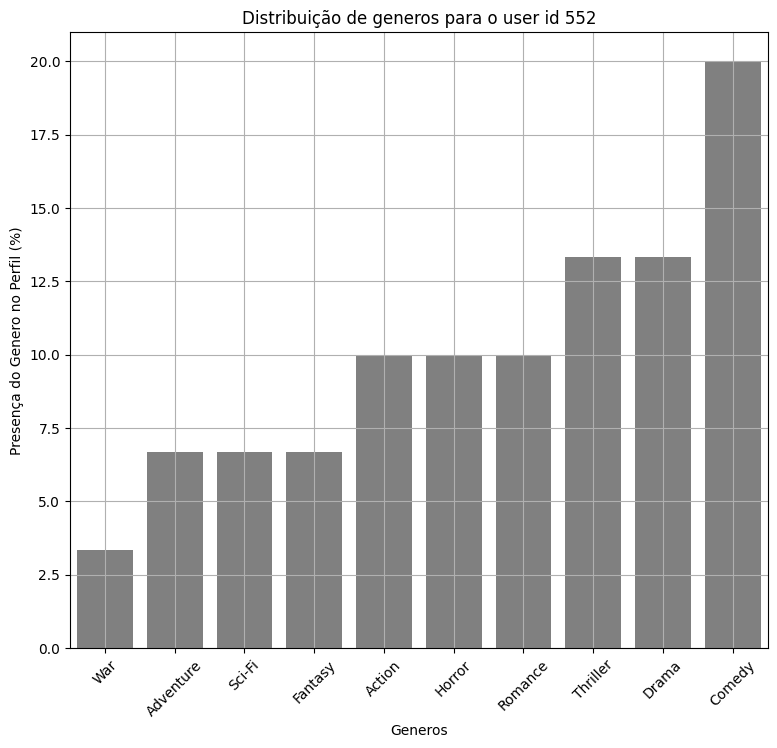

In [15]:
plot_user_genre_distribution(552)

***Exercício 03:*** Explore como outros modelos se comportam com as injustiças relacionadas ao genero do filme. Visualize as métricas para diferentes modelos.

In [78]:

reader = Reader(rating_scale = (0, 5))

trainset = Dataset.load_from_df(
    train[["user", "item", "rating"]], reader=reader
).build_full_trainset()


In [17]:
from surprise.prediction_algorithms.matrix_factorization import SVDpp

In [79]:
u_knn = KNNBasic(K=5, sim_options={"user_based": True, "similarities": 'cosine'})
i_knn = KNNBasic(K=5, sim_options={"user_based": False, "similarities": 'cosine'})
random = NormalPredictor()
svdpp = SVDpp(
    n_factors=20,
    n_epochs=20,
    lr_all=0.005,
    reg_all=0.02,
    random_state=42)

In [80]:
svdpp.fit(trainset)

In [81]:
u_knn.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [82]:
i_knn.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [83]:
test

,user,item,rating,timestamp
42825,3858,1206,3,965874884
189053,4180,1200,4,965332064
195189,1683,381,4,974708091
35952,352,866,4,976331400
90567,1426,3100,4,975441735
...,...,...,...,...
171743,1434,1556,3,974759297
15483,1228,2335,4,975631027
120220,4367,2072,2,965182490
109399,660,1079,3,975698212


In [84]:
svdpp_recs = get_recommendation_raw(svdpp, test)

In [85]:
get_mean_rank_miscalibration(svdpp_recs)

0.4270504984614694

In [25]:
i_knn_recs = get_recommendation_raw(i_knn)

In [26]:
get_mean_rank_miscalibration(i_knn_recs)

0.5184916294198939

In [27]:
u_knn_recs = get_recommendation_raw(u_knn)

In [29]:
get_mean_rank_miscalibration(u_knn_recs)

0.49983629894815673

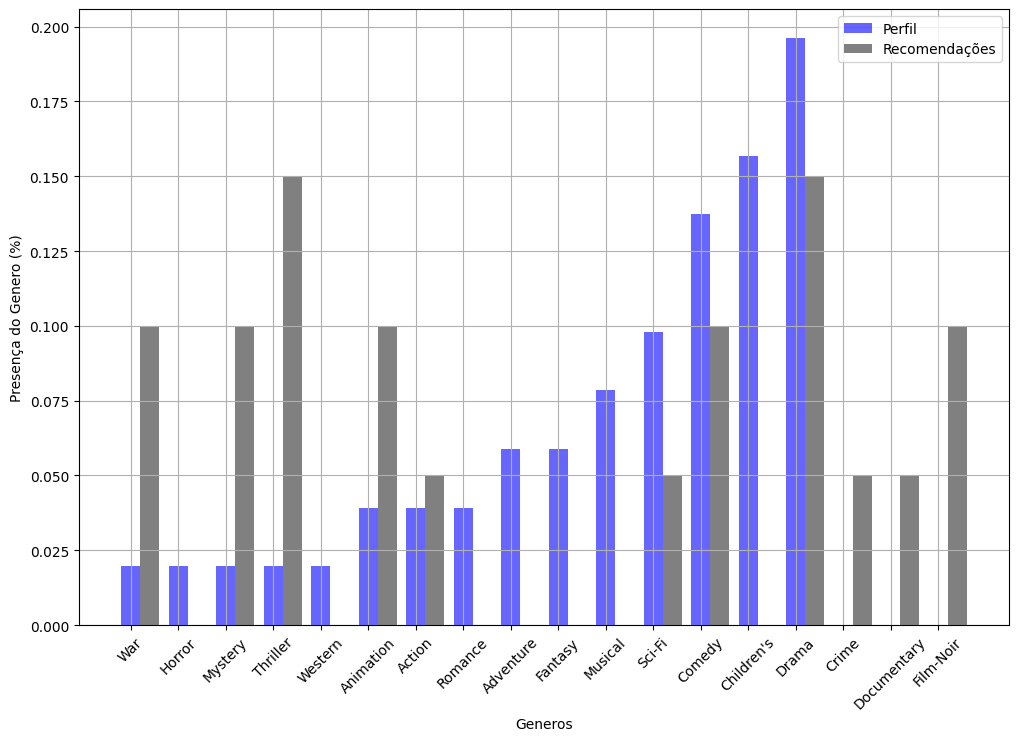

In [30]:
plot_user_recommendation_genre_distribution(svdpp_recs, 3858)

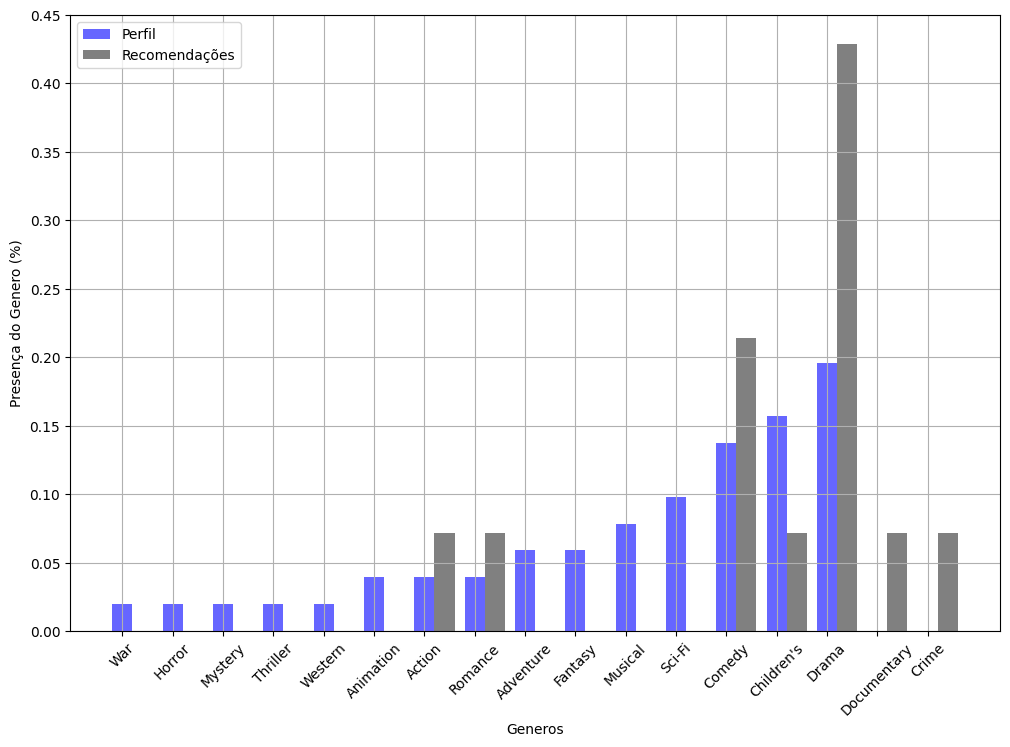

In [31]:
plot_user_recommendation_genre_distribution(u_knn_recs, 3858)

Vemos que dos três modelos testados, notamos que o svdpp apresenta o melhor resultado de MRMC, ou seja, uma calibração mais interessante. Seguido pelo i_knn e pelo u_knn, que aparenta desviar mais a recomendação em relação aos gêneros no histórico do usuário

***Exercício 04:*** Qual o efeito provocado pela variação do parâmetro $\lambda$ da calibração? Tente visualizar o efeito provocado nas métricas de fairness e acurácia se variarmos o parâmetro lambda.

Vamos fazer a verificação para o u_knn, que apresenta o pior resultado em calibração.

In [106]:
def calibrate_recommendations(model, _lambda, top_n=10):
        
    prediction_user_map_after_calibration = {}
    
    for user in tqdm.tqdm(sorted(test['user'].unique())[:500]):
        
        user_profile_distribution = get_user_profile_distribution(train, user) 

        data = {"item": list(set(df["item"].unique()))}
        user_testset_df = pd.DataFrame(data)
        user_testset_df["rating"] = 0.0
        user_testset_df["user"] = user
        
        testset = (
            Dataset.load_from_df(
                user_testset_df[["user", "item", "rating"]],
                reader=reader,
            )
            .build_full_trainset()
            .build_testset()
        )
        predictions = sorted(
            [(pred.iid, pred.est)for pred in model.test(testset) if ((pred.uid == user))],
            key=lambda x: x[1],reverse=True
        )
        reranked_list = rerank_recommendation(
            user_profile_distribution,
            predictions[:100],
            user,
            N,
            _lambda
        )
        
        prediction_user_map_after_calibration[user] = reranked_list[1]
    return prediction_user_map_after_calibration
    

In [70]:
get_mean_rank_miscalibration(i_knn_recs)

0.5184916294198939

In [72]:
get_mean_rank_miscalibration(i_knn_calibrated)

0.4185038104973506

In [95]:
tradeoff = 0.3
N = 10

i_knn_calibrated = calibrate_recommendations(i_knn, tradeoff)

100%|█████████████████████████████████████████| 500/500 [00:57<00:00,  8.66it/s]


In [96]:
get_mean_rank_miscalibration(i_knn_calibrated)

0.19119964941385056

In [107]:
lambdas = [i/10 for i in range(0,10,1)]

In [108]:
lambdas

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [109]:
calibrated_mrms = []

for idx, l in enumerate(lambdas):
    print(f"Iteração {idx+1} de {len(lambdas)} - Lambda = {l}") 
    i_knn_calibrated = calibrate_recommendations(i_knn, l)
    mrm = get_mean_rank_miscalibration(i_knn_calibrated)
    calibrated_mrms.append(mrm)

Iteração 1 de 10 - Lambda = 0.0


100%|█████████████████████████████████████████| 500/500 [00:54<00:00,  9.16it/s]


Iteração 2 de 10 - Lambda = 0.1


100%|█████████████████████████████████████████| 500/500 [00:58<00:00,  8.61it/s]


Iteração 3 de 10 - Lambda = 0.2


100%|█████████████████████████████████████████| 500/500 [00:54<00:00,  9.22it/s]


Iteração 4 de 10 - Lambda = 0.3


100%|█████████████████████████████████████████| 500/500 [00:54<00:00,  9.21it/s]


Iteração 5 de 10 - Lambda = 0.4


100%|█████████████████████████████████████████| 500/500 [00:54<00:00,  9.24it/s]


Iteração 6 de 10 - Lambda = 0.5


100%|█████████████████████████████████████████| 500/500 [00:53<00:00,  9.28it/s]


Iteração 7 de 10 - Lambda = 0.6


100%|█████████████████████████████████████████| 500/500 [00:54<00:00,  9.23it/s]


Iteração 8 de 10 - Lambda = 0.7


100%|█████████████████████████████████████████| 500/500 [00:54<00:00,  9.20it/s]


Iteração 9 de 10 - Lambda = 0.8


100%|█████████████████████████████████████████| 500/500 [00:54<00:00,  9.22it/s]


Iteração 10 de 10 - Lambda = 0.9


100%|█████████████████████████████████████████| 500/500 [00:54<00:00,  9.19it/s]


In [110]:
calibrated_mrms

[0.5224074631229152,
 0.19119964941385056,
 0.17954950446918455,
 0.164628656406311,
 0.1551474410209468,
 0.14792907295116547,
 0.14324050925446474,
 0.1400997955056366,
 0.13815339630154327,
 0.13718579346292384]

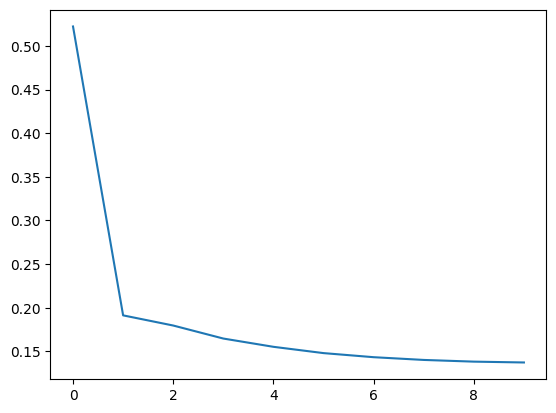

In [111]:
plt.plot(calibrated_mrms)

Note como o aumento do parâmetro lambda melhora a calibração, pela métrica de MRMC. Isso faz sentido, dado que maiores valores de lambda causam um aumento de importância da calibração e diminuição da importância do score atribuído pelo algoritmo de recomendação